# Setup and Install

In [ ]:
import os
import shutil
import torch
from google.colab import drive

!pip install -q roboflow ultralytics # Install required libraries

drive.mount('/content/drive') 

DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/Deep_Learning' # Root directory in Google Drive
DRIVE_WEIGHTS_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'weights')
DRIVE_RUNS_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'runs')

# Create directories if they don't exist
os.makedirs(DRIVE_WEIGHTS_DIR, exist_ok=True)
os.makedirs(DRIVE_RUNS_DIR, exist_ok=True)

print(f" Setup Complete. GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 105.5 MB/s eta 0:00:00
Mounted at /content/drive
 Setup Complete. GPU Available: True
   GPU Name: NVIDIA A100-SXM4-40GB


# Download and Merge Datasets

In [ ]:
from roboflow import Roboflow
from ultralytics import settings


settings.update({'datasets_dir': '/content/datasets'}) # Set datasets directory to Colab local disk for speed at first

def download_data_fast():
    print(" Downloading dataset from Roboflow to local Colab disk")

    rf = Roboflow(api_key="8gFJp7Eu2sWslubjUHwI") # API Key from Roboflow
    project = rf.workspace("visualizan2").project("c1-zhnfm")
    version = project.version(1)

    dataset = version.download("yolov11") # Download in YOLOv11 format

    print(f" Dataset ready at: {dataset.location}")
    return dataset, f"{dataset.location}/data.yaml"


# Execute Download
dataset_obj, data_yaml_path = download_data_fast()

local_dataset = '/content/local_dataset' # Path tolocal dataset in Colab

def merge_datasets(source_root, target_root):
    # Iterate through 'train', 'valid', and 'test' sets
    for subset in ['train', 'valid', 'test']:
        for folder in ['images', 'labels']:
            source_dir = os.path.join(source_root, subset, folder)
            target_dir = os.path.join(target_root, subset, folder)

            # Check if source directory exists
            if os.path.exists(source_dir) and os.path.exists(target_dir):
                files = os.listdir(source_dir)
                print(f"--> Copying {len(files)} files to: {subset}/{folder}")

                for file_name in files:
                    full_file_name = os.path.join(source_dir, file_name)
                    if os.path.isfile(full_file_name):
                        shutil.copy(full_file_name, target_dir)
            else:
                pass

# Check if manual path exists and run the merge
if os.path.exists(local_dataset):
    merge_datasets(local_dataset, dataset_obj.location)
else:
    print(f"WARNING: local dataset path not found: {local_dataset}. Proceeding with Roboflow data only.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to C1-1 in yolov11:: 100%|██████████| 19546/19546 [00:02<00:00, 7309.28it/s]


 Dataset ready at: /content/C1-1


# Train RT-DETR

In [ ]:
from ultralytics import RTDETR
import datetime

# Configuration for RT-DETR
MODEL_TYPE = 'rtdetr-l.pt'  # We used RT-DETR Large
EPOCHS = 30                 
BATCH_SIZE = 16           
IMG_SIZE = 640

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M") # Timestamp for unique run name
run_name = f"chess_rtdetr_l_{timestamp}"

print(f"\n{'='*20} Starting Training: {run_name} {'='*20}")

if torch.cuda.is_available():
    torch.cuda.empty_cache() # Clear GPU cache before training

# Load Model
model = RTDETR(MODEL_TYPE)

# Train
results = model.train(
    data=data_yaml_path,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    optimizer='AdamW',
    lr0=0.0001,
    cos_lr=True,
    project='/content/runs/detect',
    name=run_name,
    seed=42,
    patience=10,
    plots=True,
    exist_ok=True,
    workers=16
)

print(f"Training Finished. Results saved locally to /content/runs/detect/{run_name}")


==================== Starting Training: chess_rtdetr_l_20251224_1436 ====================
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/C1-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chess_rtdetr_l_20251224_1436, nbs=64, n

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       1/30      16.3G     0.7595     0.9426     0.2135        444        640: 100% ━━━━━━━━━━━━ 427/427 2.3it/s 3:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 3.5it/s 17.7s
                   all       1960      43525      0.765      0.725       0.66      0.434

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/30      17.6G     0.7244     0.5662     0.1442        572        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       2/30      18.3G     0.5221     0.5291     0.1127        426        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:44
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.8s
                   all       1960      43525      0.849      0.805       0.79      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/30      18.4G     0.4739     0.5384     0.1046        351        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       3/30      18.4G      0.496      0.499     0.1058        513        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525       0.85      0.818      0.804      0.546

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/30      18.5G     0.4124     0.4731    0.09229        383        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       4/30      18.5G     0.4871     0.4874     0.1014        572        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.8s
                   all       1960      43525      0.871      0.825      0.825      0.564

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/30      18.6G     0.7415     0.5734     0.1835        589        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       5/30      18.6G     0.4711     0.4822    0.09694        380        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.881      0.838      0.842      0.584

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/30      18.7G     0.4795     0.4677    0.09418        529        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       6/30      18.7G     0.4528     0.4704    0.09123        261        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.918      0.829      0.855      0.598

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/30      18.7G     0.4006     0.4862    0.05742        713        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       7/30      19.5G     0.4436     0.4687    0.08982        625        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.902      0.839      0.852      0.598

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/30      19.6G     0.4384     0.4442    0.08116        669        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       8/30      19.6G       0.44     0.4608    0.08752        370        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.901      0.841      0.858      0.613

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/30      19.7G     0.5892     0.4421     0.0961        643        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       9/30      19.7G     0.4324     0.4571    0.08635        471        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.907      0.852      0.859      0.613

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/30      19.7G     0.3719      0.499    0.06364        496        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      10/30      19.7G     0.4292     0.4586    0.08515        571        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.913      0.846      0.867      0.617

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/30      19.8G     0.5346     0.4752     0.1045        528        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      11/30      19.8G     0.4143      0.449    0.08193        423        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.911      0.852      0.866      0.625

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/30      13.6G      0.561     0.4833     0.1064        601        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      12/30      13.6G     0.4152     0.4467    0.08226        328        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.934      0.834      0.872      0.624

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/30      13.6G     0.4703     0.4454    0.08406        393        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      13/30      14.8G     0.4177     0.4498    0.08239        358        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.923      0.847      0.867      0.621

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/30      14.8G     0.3741     0.4729    0.07303        513        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      14/30      14.8G     0.4102     0.4447    0.08025        536        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.922      0.843      0.873      0.628

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/30      14.8G     0.5778     0.4625     0.1353        437        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      15/30      14.9G      0.407     0.4431    0.07907        450        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.923      0.852      0.874      0.636

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/30        15G     0.5764     0.4721     0.1067        456        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      16/30        15G     0.4017     0.4425    0.07849        480        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.913      0.855      0.865       0.63

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/30      15.1G      0.587     0.5047     0.1233        405        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      17/30      15.1G     0.3989     0.4374     0.0772        388        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.932      0.854       0.87      0.634

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/30      15.2G     0.5111     0.4281    0.08328        638        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      18/30      15.2G     0.3953     0.4347    0.07656        399        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.933      0.854      0.875       0.64

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/30      15.2G     0.3629     0.4418    0.07506        444        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      19/30      15.3G     0.3877     0.4298     0.0751        691        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.932      0.855      0.873      0.632

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/30      15.3G     0.3483     0.4425    0.07127        420        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      20/30      15.4G     0.3929     0.4306    0.07618        403        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.916      0.863      0.868      0.637
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/30      15.4G     0.5184     0.4398    0.09837        259        640: 0% ──────────── 0/427  1.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      21/30      15.4G     0.3714     0.4097     0.0855        334        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.903      0.865      0.852      0.625

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/30      15.5G      0.429     0.4308    0.06994        321        640: 0% ──────────── 0/427  0.3s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      22/30      15.5G     0.3693     0.4028    0.08424        492        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.927      0.844      0.873      0.641

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/30      15.6G     0.2872     0.3817    0.07317        367        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      23/30      15.6G     0.3602     0.3984    0.08102        307        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.938      0.855      0.879      0.645

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/30      15.7G     0.3173     0.3584    0.06474        442        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      24/30      15.7G     0.3552     0.3982    0.07993        229        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.922      0.862      0.876      0.649

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/30      15.8G     0.3656     0.3843    0.06542        388        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      25/30      15.8G      0.351      0.394    0.07826        317        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.943      0.853      0.878      0.649

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/30      15.9G     0.4929     0.4333    0.09186        307        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      26/30      15.9G     0.3514     0.3914    0.07888        343        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525       0.94      0.861       0.88      0.651

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/30      15.9G     0.3511     0.4092     0.1013        358        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      27/30        16G     0.3427     0.3884     0.0765        311        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.941      0.854      0.877      0.649

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/30      16.1G     0.2952     0.3546      0.068        287        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      28/30      16.1G     0.3378     0.3852    0.07533        270        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.941      0.858      0.879      0.656

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/30      16.2G     0.3447     0.3908    0.07727        407        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      29/30      16.2G     0.3347     0.3813    0.07432        313        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.941       0.86      0.878      0.655

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/30      16.2G     0.2597     0.3325    0.04987        391        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      30/30      16.2G     0.3309     0.3788    0.07294        264        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.942       0.86       0.88      0.656

30 epochs completed in 1.457 hours.
Optimizer stripped from /content/runs/detect/chess_rtdetr_l_20251224_1436/weights/last.pt, 66.3MB
Optimizer stripped from /content/runs/detect/chess_rtdetr_l_20251224_1436/weights/best.pt, 66.3MB

Validating /content/runs/detect/chess_rtdetr_l_20251224_1436/weights/best.pt...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
rt-detr-l summary: 310 layers, 32,008,400 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.4it/s 14.2s
                   all       1960      43525   

# Save Results to Drive

In [ ]:
import shutil

def backup_results():
    print("Backing up results to Google Drive")

    local_run_dir = f'/content/runs/detect/{run_name}' 

    drive_dest_dir = os.path.join(DRIVE_RUNS_DIR, run_name)

    if os.path.exists(local_run_dir):
        # Copy the entire folder
        shutil.copytree(local_run_dir, drive_dest_dir)
        print(f"   Full run directory copied to: {drive_dest_dir}")

        # Copy the best weights separately
        local_best_pt = os.path.join(local_run_dir, 'weights', 'best.pt')
        if os.path.exists(local_best_pt):
            drive_weights_path = os.path.join(DRIVE_WEIGHTS_DIR, f"best_{run_name}.pt")
            shutil.copy(local_best_pt, drive_weights_path)
            print(f" Best weights saved to: {drive_weights_path}")

        print("Backup Complete")
    else:
        print(f"Error: Local run directory not found: {local_run_dir}")

backup_results()

Backing up results to Google Drive...
   Full run directory copied to: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251224_1436
 Best weights saved to: /content/drive/MyDrive/Deep_Learning/weights/best_chess_rtdetr_l_20251224_1436.pt
Backup Complete!


# Show Training Metrics

Inspecting results from: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251224_1436
Test images found in Drive: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

==================== 1. TRAINING METRICS ====================

--- Loss and Metrics Curves ---


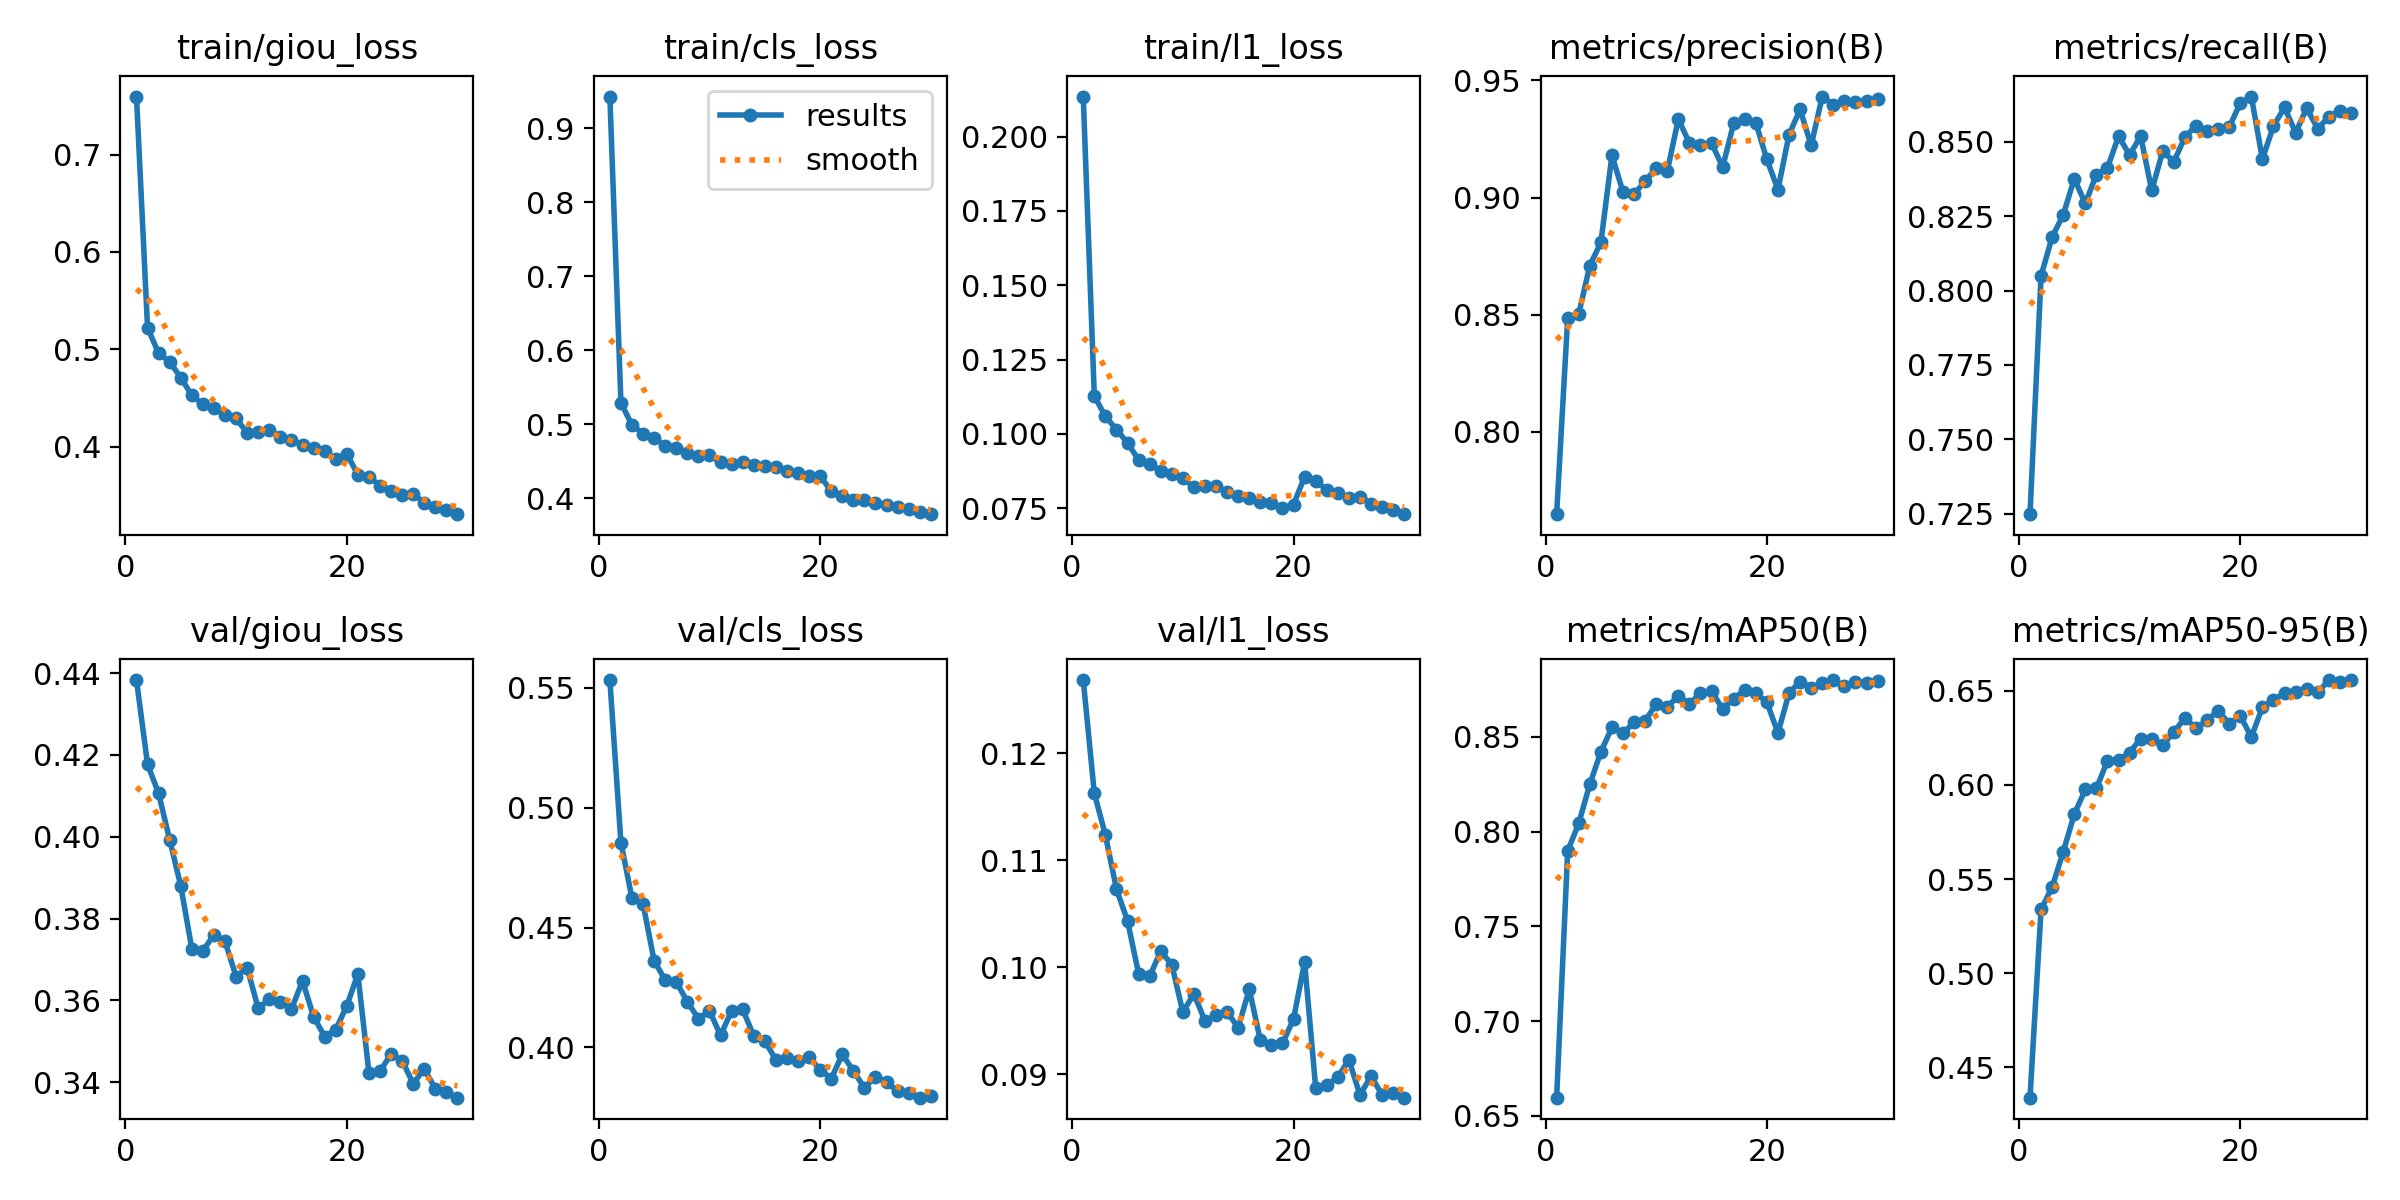


--- Confusion Matrix (Normalized) ---


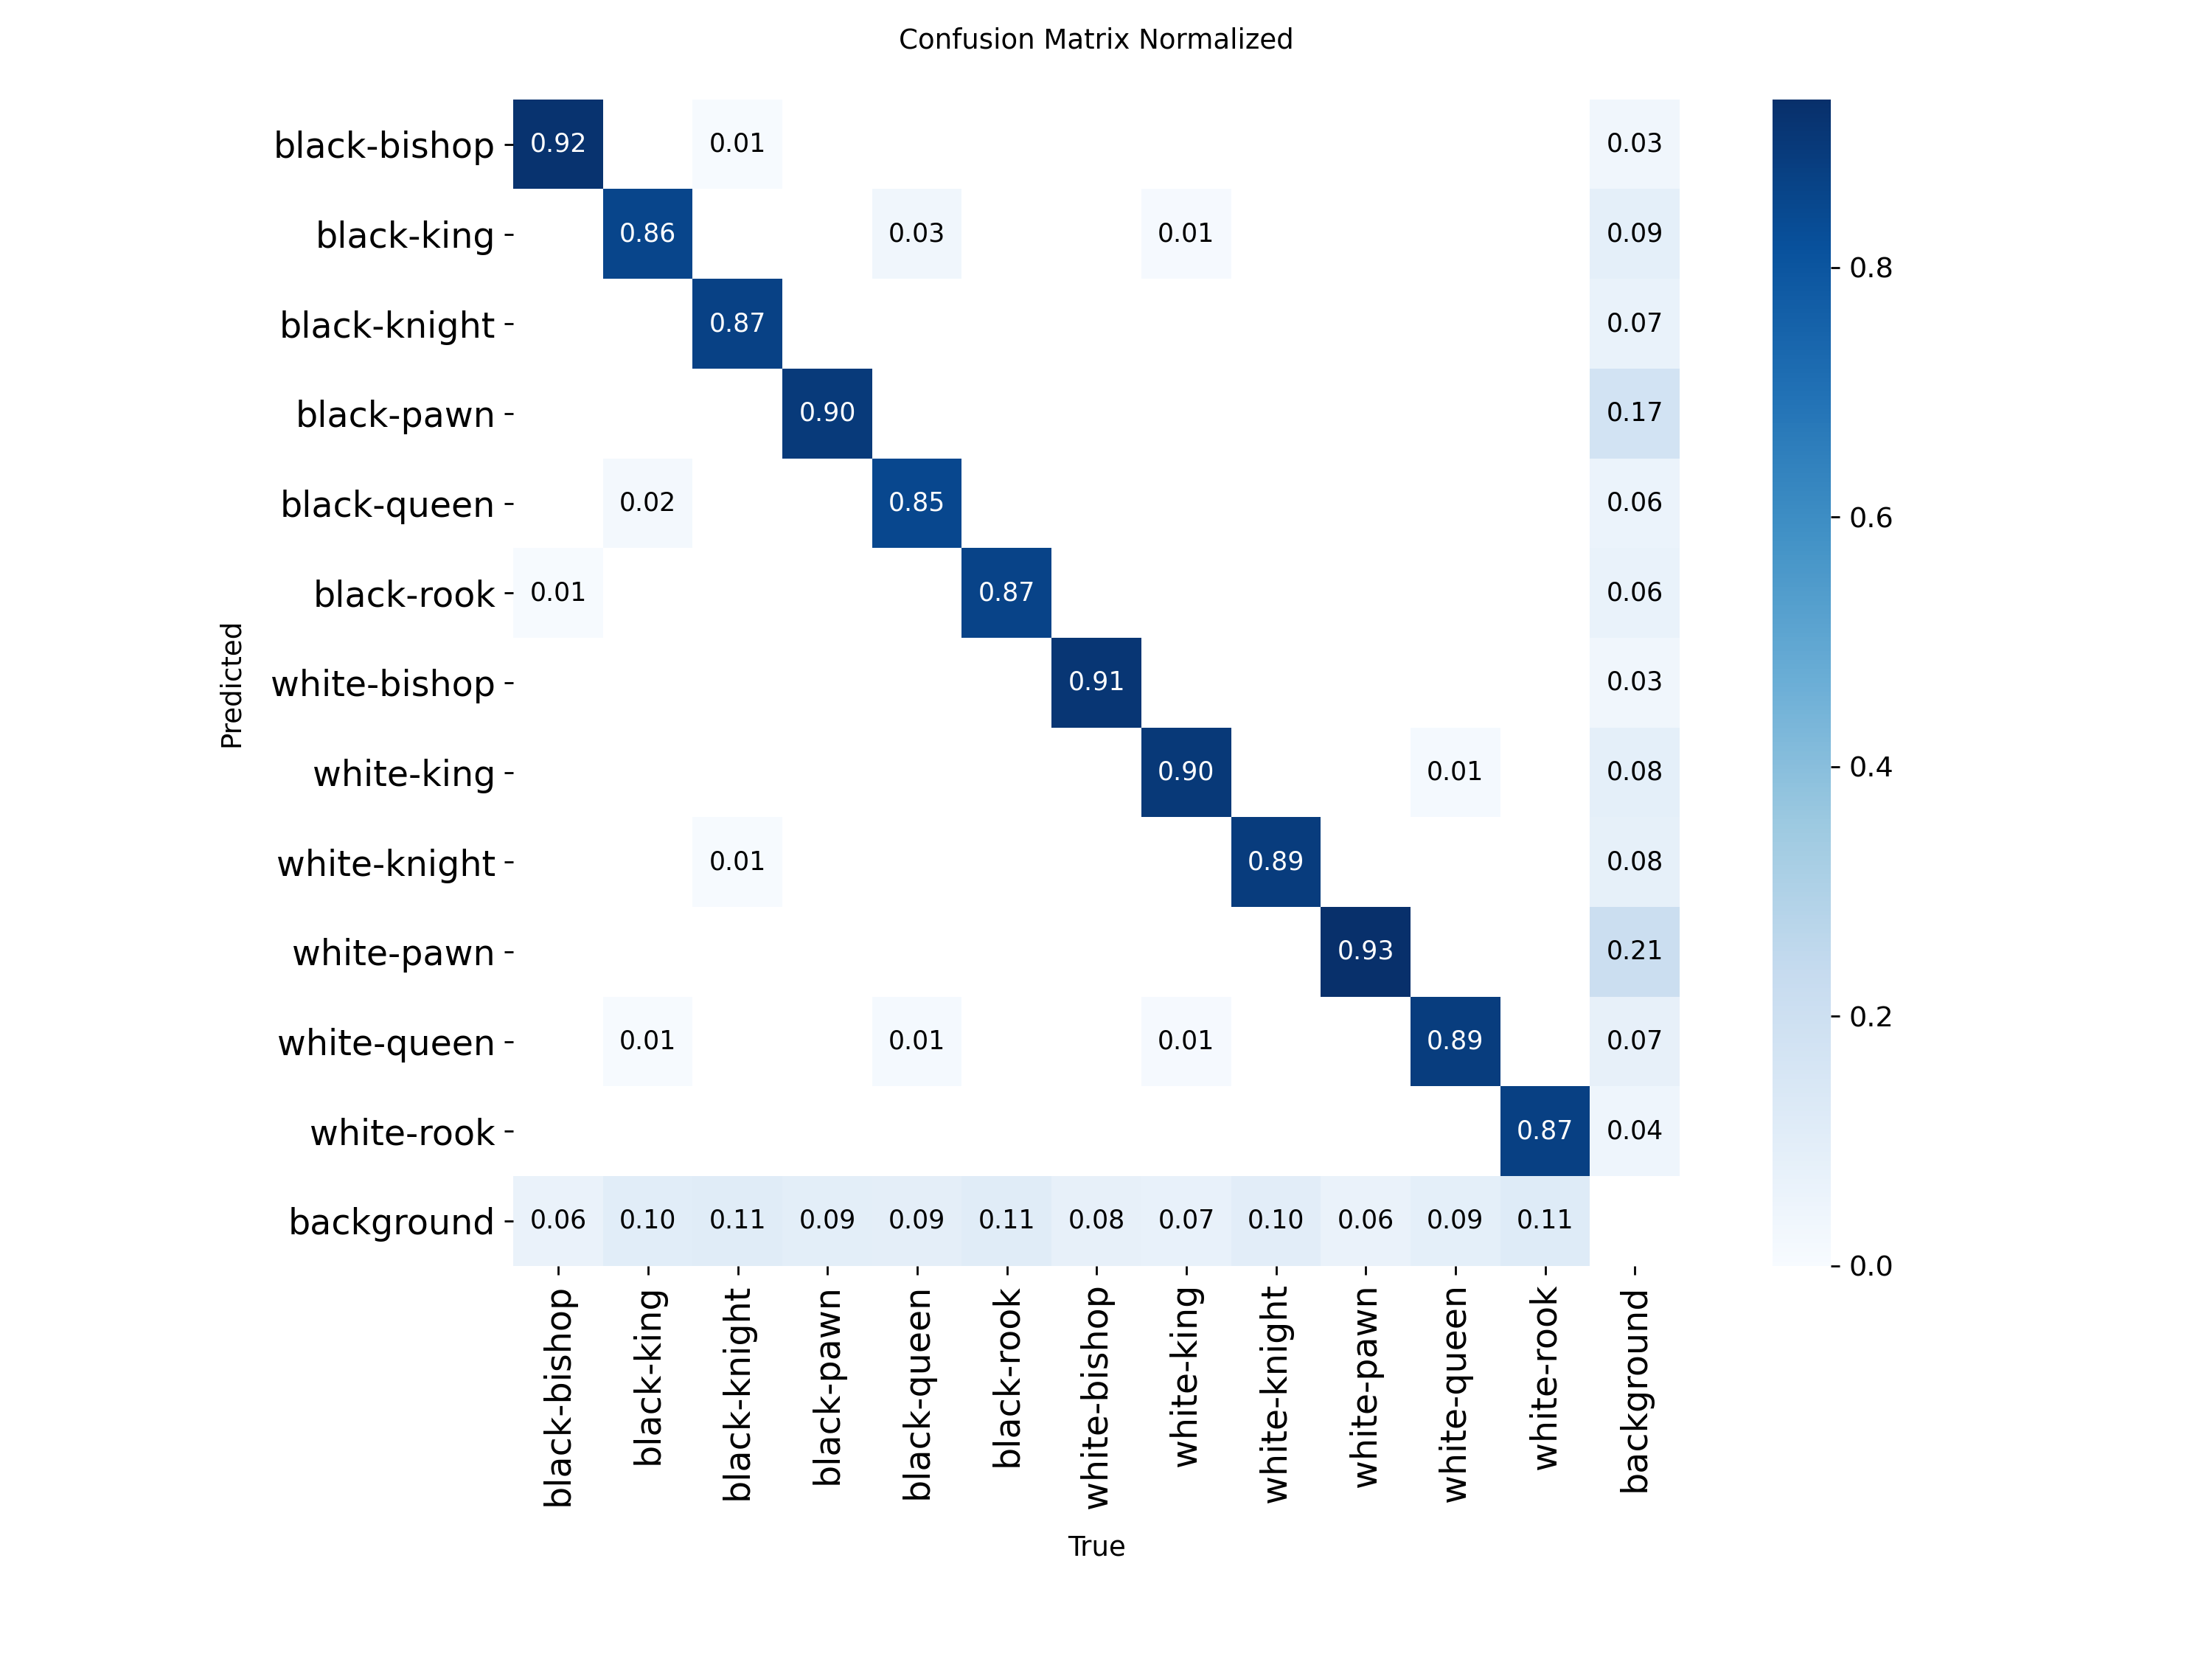


--- Dataset Labels ---


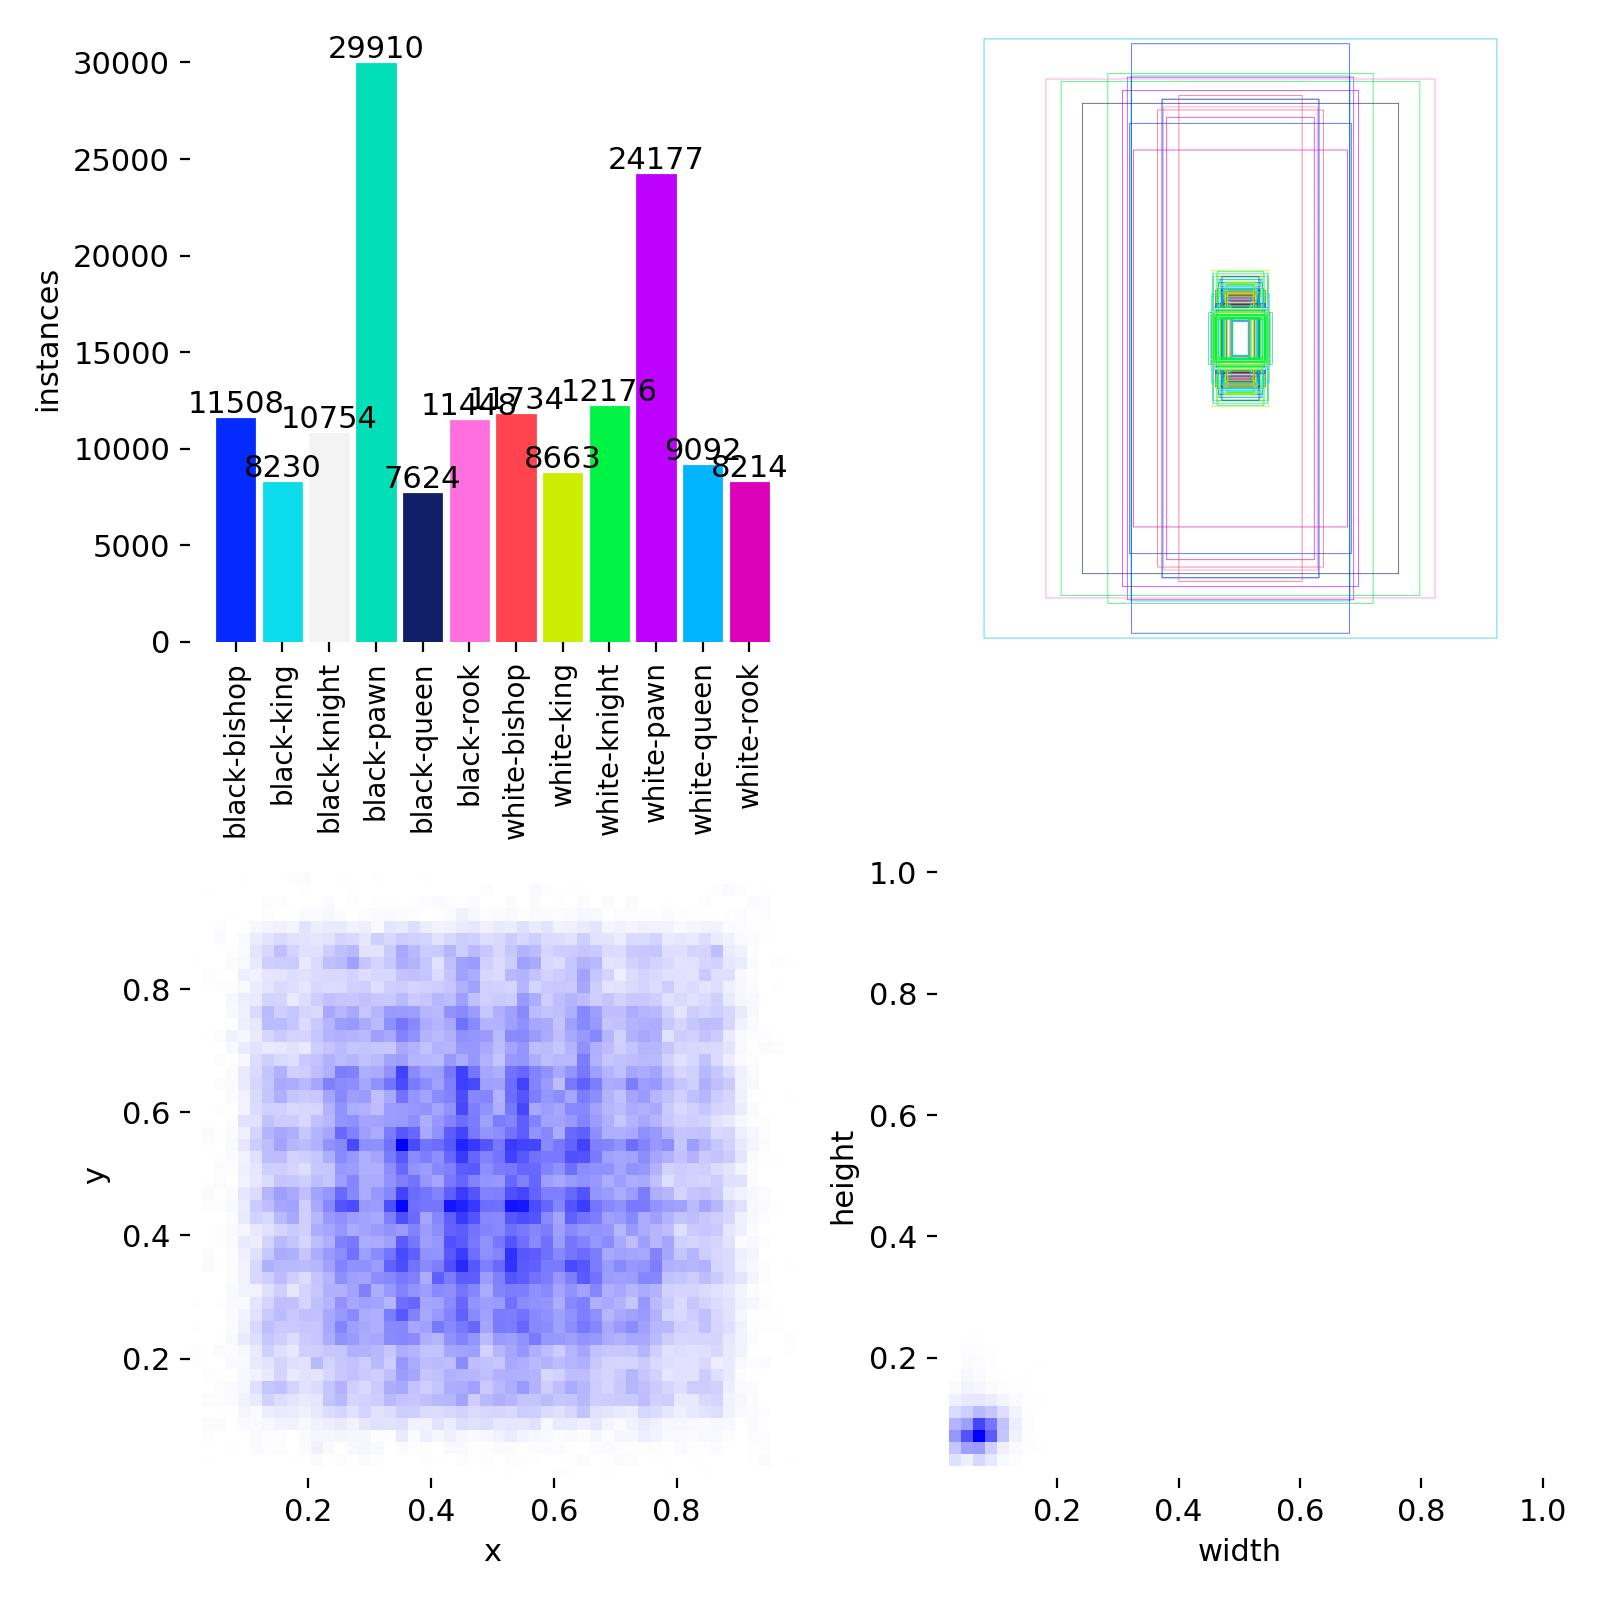


==================== 2. VISUAL PREDICTIONS (TEST SET) ====================


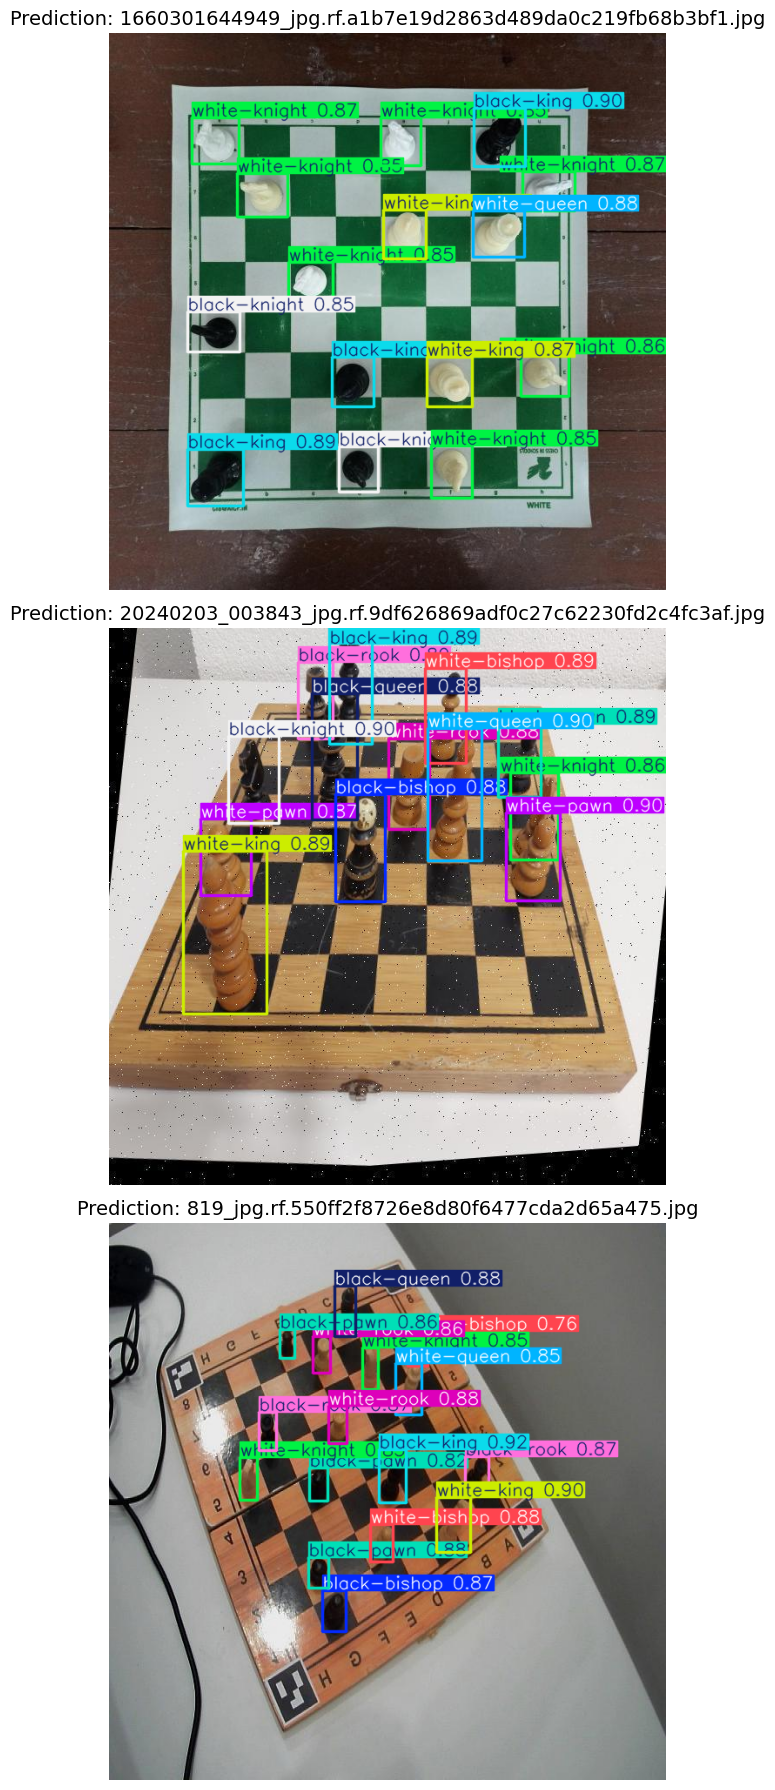

In [ ]:
import os
import glob
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO, RTDETR
from IPython.display import Image, display
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

run_name = 'chess_rtdetr_l_20251224_1436' 

# Project root directory on Drive
DRIVE_ROOT = '/content/drive/MyDrive/Deep_Learning'

# Construct full paths
RUN_DIR = os.path.join(DRIVE_ROOT, 'runs', run_name)
BEST_MODEL_PATH = os.path.join(RUN_DIR, 'weights', 'best.pt')

print(f"Inspecting results from: {RUN_DIR}")

# Check if run directory exists
if not os.path.exists(RUN_DIR):
    print(f"Error: The folder '{run_name}' was not found in {os.path.join(DRIVE_ROOT, 'runs')}")
    print("Please check the folder name in your Google Drive and update run_name.")
else:
    # Locate test images
    drive_test_search = os.path.join(DRIVE_ROOT, 'datasets', '*', 'test', 'images')
    found_drive_test = glob.glob(drive_test_search)

    if found_drive_test:
        TEST_IMAGES_PATH = found_drive_test[0]
        print(f"Test images found in Drive: {TEST_IMAGES_PATH}")
    else:
        # Fallback: local storage
        local_test_path = '/content/datasets/c1-zhnfm-1/test/images'
        if not os.path.exists(local_test_path):
            local_test_path = '/content/datasets/c1-zhnfm-1/valid/images'
        TEST_IMAGES_PATH = local_test_path

        if os.path.exists(TEST_IMAGES_PATH):
            print(f"Test images found locally: {TEST_IMAGES_PATH}")
        else:
            print("Error: Test images could not be found in Drive or local storage.")

    def display_training_metrics(): # Displays standard plots generated by Ultralytics during training.

        print("\n" + "=" * 20 + " 1. TRAINING METRICS " + "=" * 20)

        # Standard Ultralytics output plots
        plots_to_show = [
            ('results.png', 'Loss and Metrics Curves'),
            ('confusion_matrix_normalized.png', 'Confusion Matrix (Normalized)'),
            ('labels.jpg', 'Dataset Labels')
        ]

        for filename, title in plots_to_show:
            filepath = os.path.join(RUN_DIR, filename)
            if os.path.exists(filepath):
                print(f"\n--- {title} ---")
                display(Image(filename=filepath, width=800))
            else:
                print(f"WARNING: {filename} was not found. It may only be generated at the end of training.")

    def run_visual_inference(num_images=3):
        """
        Loads the best model from Drive, runs inference on random test images,
        and displays the predictions.
        """
        print("\n" + "=" * 20 + " 2. VISUAL PREDICTIONS (TEST SET) " + "=" * 20)

        # Check if weights exist
        if not os.path.exists(BEST_MODEL_PATH):
            print(f"Error: Best model weights not found at: {BEST_MODEL_PATH}")
            return

        # The YOLO class can load RT-DETR weights for inference
        model = YOLO(BEST_MODEL_PATH)

        # Collect test images
        all_images = glob.glob(f"{TEST_IMAGES_PATH}/*.jpg")

        if len(all_images) == 0:
            print(f"Error: No images found in {TEST_IMAGES_PATH}")
            return

        # Randomly select images
        selected_images = random.sample(all_images, min(len(all_images), num_images))

        # Run inference
        results = model.predict(
            source=selected_images,
            conf=0.25,
            iou=0.45,
            save=False,
            verbose=False
        )

        # Display predictions
        plt.figure(figsize=(15, 6 * num_images))

        for i, r in enumerate(results):
            im_bgr = r.plot(line_width=2, font_size=2)
            im_rgb = im_bgr[..., ::-1]  # Convert BGR to RGB

            plt.subplot(num_images, 1, i + 1)
            plt.imshow(im_rgb)
            plt.axis('off')
            plt.title(f"Prediction: {os.path.basename(selected_images[i])}", fontsize=14)

        plt.tight_layout()
        plt.show()

    display_training_metrics()
    run_visual_inference(num_images=3)


# Analyze Model Confidence

Loading model from: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251224_1436/weights/best.pt
Analyzing images in: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images
Processing 976 images sequentially to save memory...


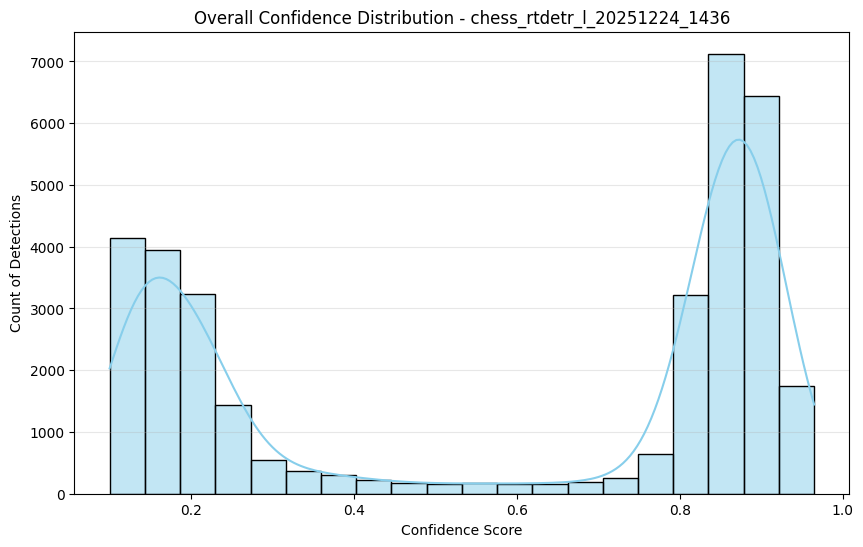



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



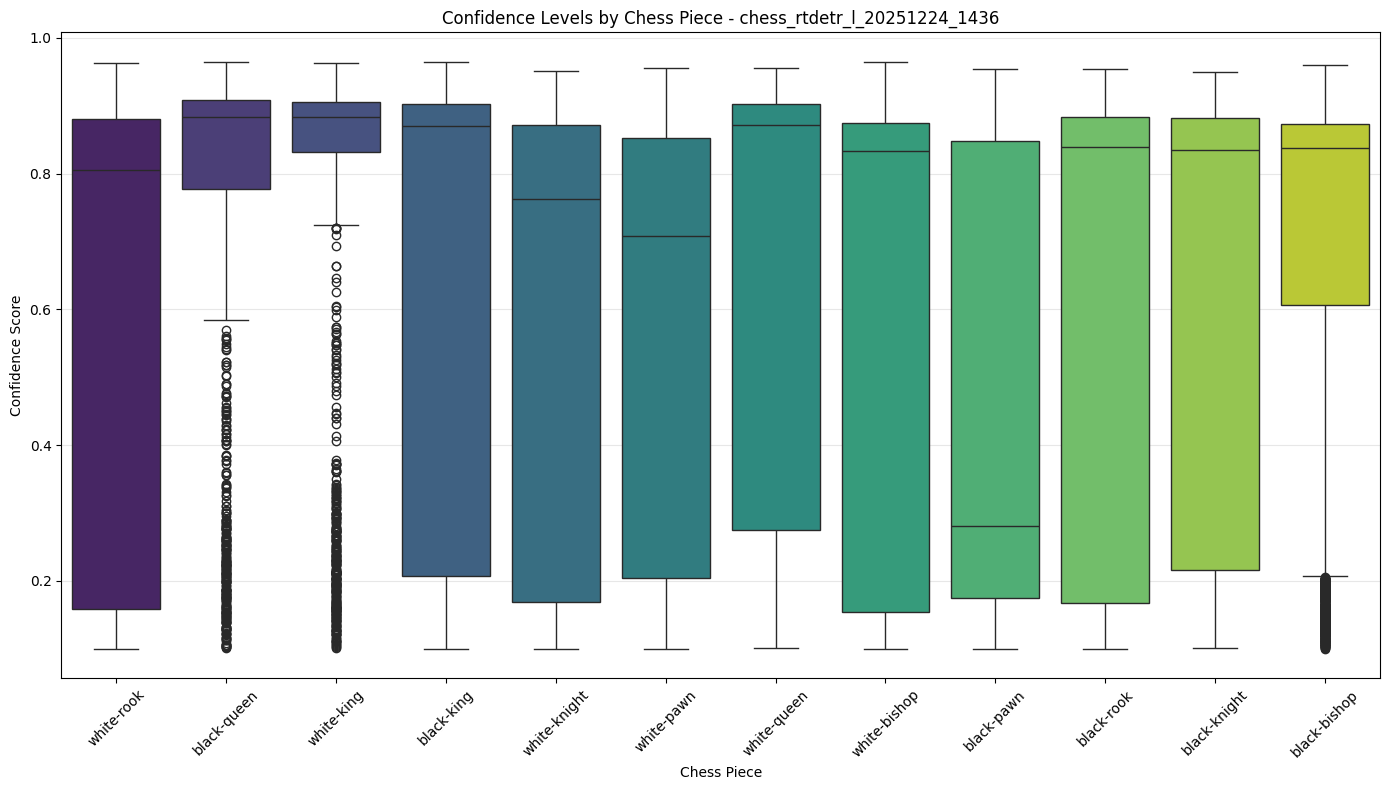

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import gc

run_name = 'chess_rtdetr_l_20251224_1436'

DRIVE_ROOT = '/content/drive/MyDrive/Deep_Learning'
RUN_DIR = os.path.join(DRIVE_ROOT, 'runs', run_name)
BEST_MODEL_PATH = os.path.join(RUN_DIR, 'weights', 'best.pt')

# Locate Test Images
drive_test_search = os.path.join(DRIVE_ROOT, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    TEST_IMAGES_DIR = found_drive_test[0]
else:
    TEST_IMAGES_DIR = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(TEST_IMAGES_DIR):
        TEST_IMAGES_DIR = '/content/datasets/c1-zhnfm-1/valid/images'

def plot_confidence_analysis(model_path, images_dir):
    # Clear Memory Before Starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if not os.path.exists(model_path):
        print(f"Error: Model weights not found at {model_path}")
        return

    print(f"Loading model from: {model_path}")
    print(f"Analyzing images in: {images_dir}")

    # Load Model
    model = YOLO(model_path)
    image_files = glob.glob(f"{images_dir}/*.jpg")

    if not image_files:
        print("No images found.")
        return

    # Collect data
    all_confs = []
    all_classes = []

    print(f"Processing {len(image_files)} images sequentially to save memory...")

    # We loop through files manually to ensure memory is released after each image
    for i, img_path in enumerate(image_files):
        try:
            results = model.predict(img_path, conf=0.1, verbose=False, device=0)

            for r in results:
                if r.boxes:
                    confs = r.boxes.conf.cpu().numpy()
                    clss = r.boxes.cls.cpu().numpy().astype(int)
                    class_names = r.names

                    all_confs.extend(confs)
                    all_classes.extend([class_names[c] for c in clss])
        except Exception as e:
            print(f"Skipping image {i} due to error: {e}")
            continue

    # Create DataFrame for plotting
    df = pd.DataFrame({'Confidence': all_confs, 'Class': all_classes})

    if df.empty:
        print("No detections made on the test set.")
        return

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Confidence', bins=20, kde=True, color='skyblue')
    plt.title(f'Overall Confidence Distribution - {run_name}')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count of Detections')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Class', y='Confidence', palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'Confidence Levels by Chess Piece - {run_name}')
    plt.xlabel('Chess Piece')
    plt.ylabel('Confidence Score')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_confidence_analysis(BEST_MODEL_PATH, TEST_IMAGES_DIR)

# Advanced Evaluation

Analysis started for run: chess_rtdetr_l_20251224_1436
Model path: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251224_1436/weights/best.pt
Test Images: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

Computing class-wise mAP...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
rt-detr-l summary: 310 layers, 32,008,400 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 52.6±25.4 MB/s, size: 80.9 KB)
val: Scanning /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 976/976 1.5Mit/s 0.0s
val: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images/IMG_20200909_000652_jpg.rf.915eb2770aef574ef4eae9a12de1e2b8.jpg: 2 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 61/61 5.2it/s 11.7s
              



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



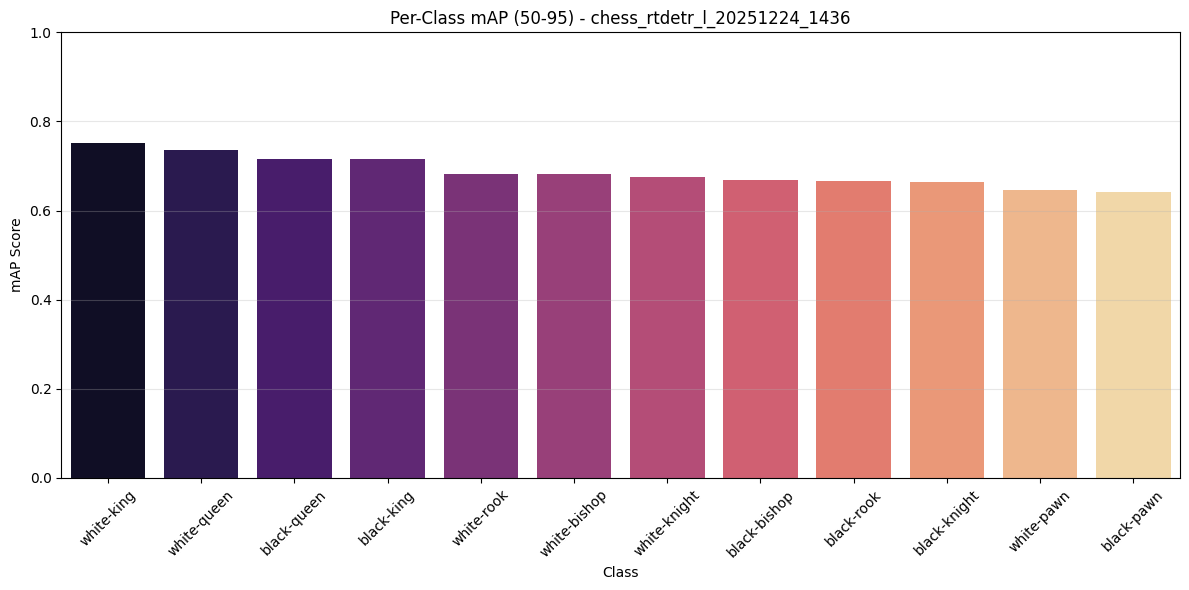


--- Confusion Matrix ---


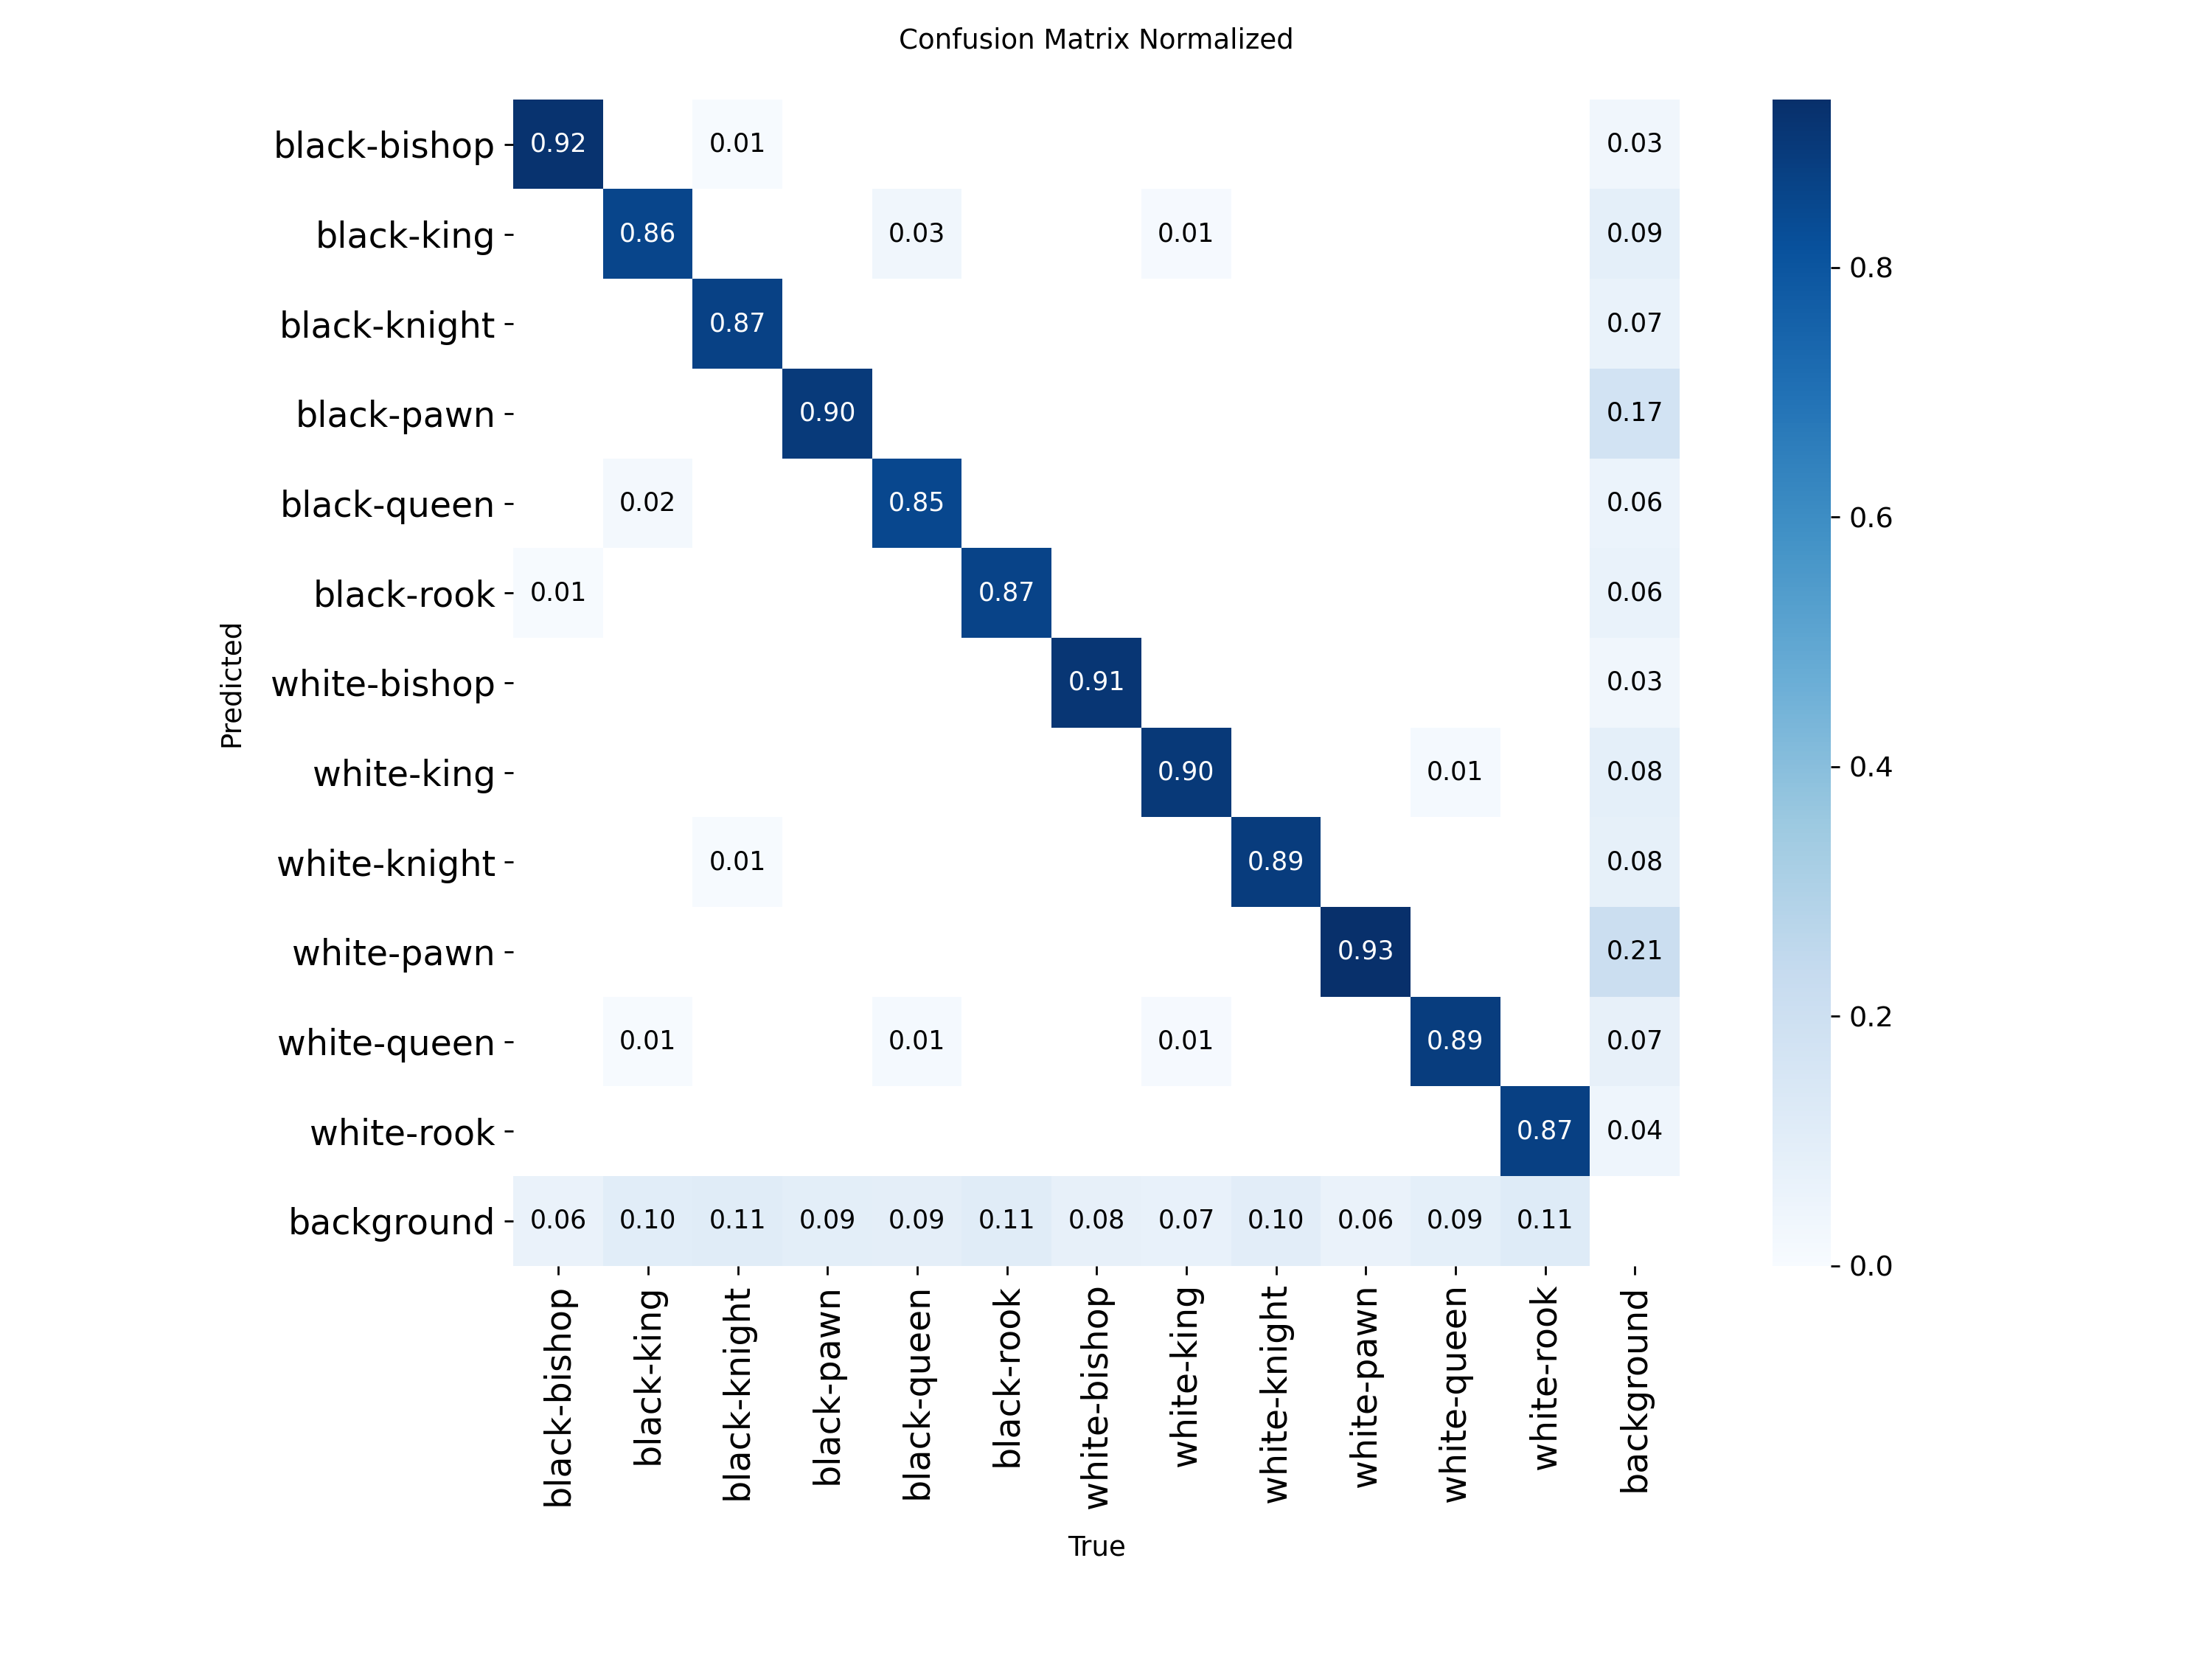


--- 1. Class Distribution Analysis (Ground Truth) ---




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



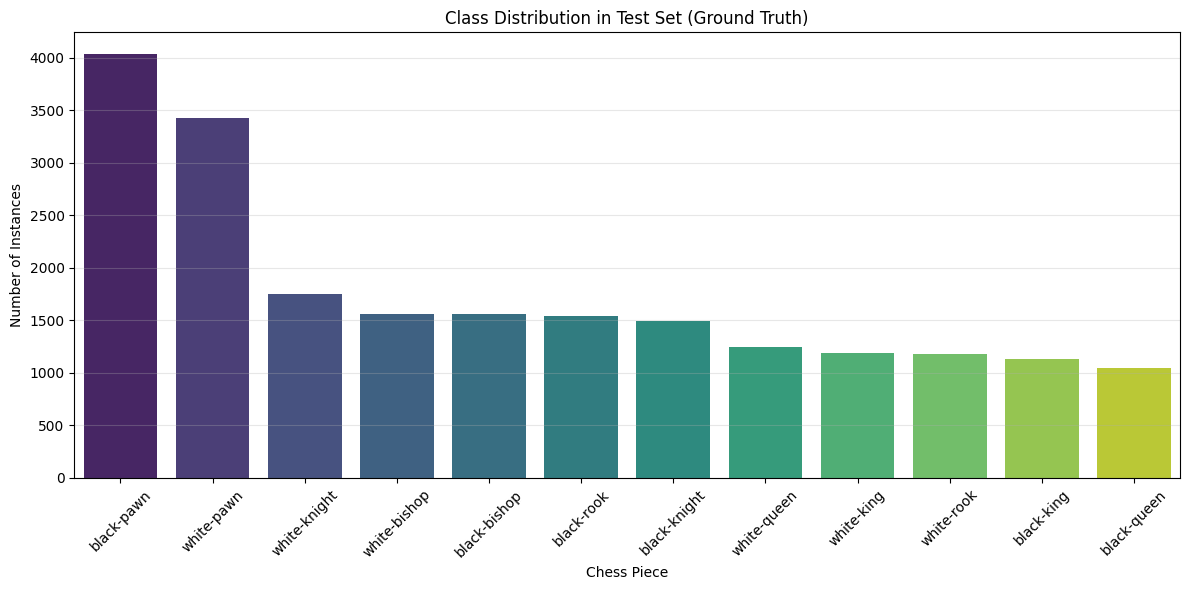


--- 2. Worst Predictions Gallery (Lowest Confidence) ---
Running sequential inference to find hard samples (Memory Safe)...
Plotting 6 worst cases...


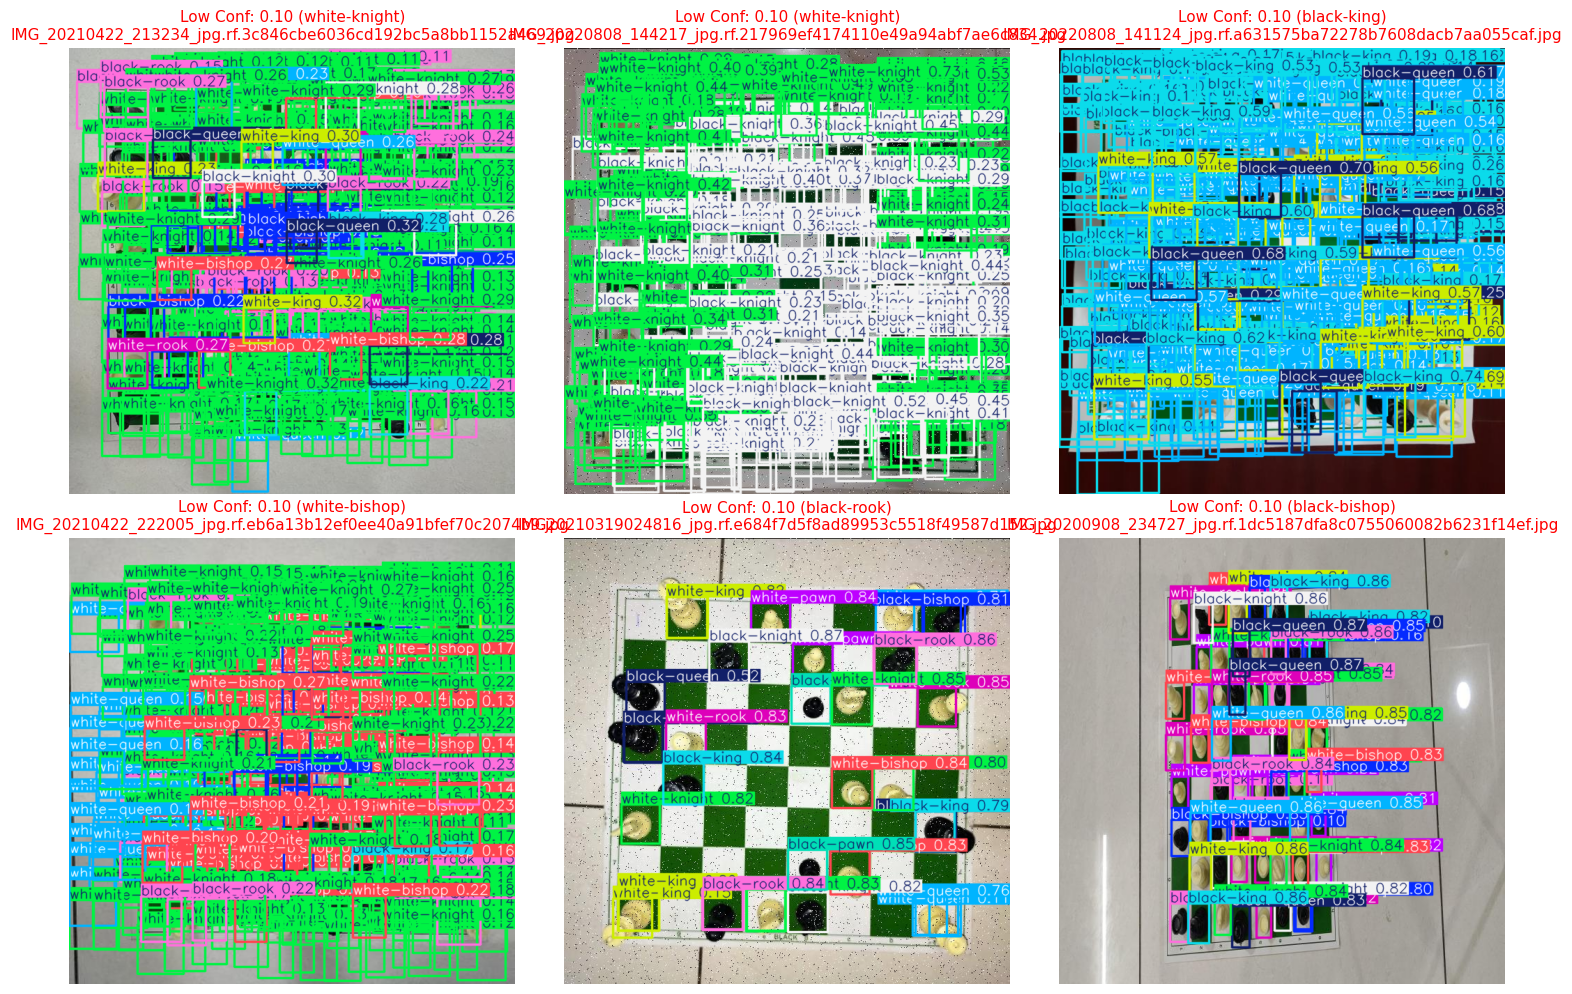

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import gc
from collections import Counter
from IPython.display import Image, display


run_name = 'chess_rtdetr_l_20251224_1436'

DRIVE_ROOT = '/content/drive/MyDrive/Deep_Learning'
RUN_DIR = os.path.join(DRIVE_ROOT, 'runs', run_name)
BEST_MODEL_PATH = os.path.join(RUN_DIR, 'weights', 'best.pt')

# Locate Images and Labels
drive_test_search = os.path.join(DRIVE_ROOT, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    TEST_IMAGES_DIR = found_drive_test[0]
else:
    TEST_IMAGES_DIR = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(TEST_IMAGES_DIR):
        TEST_IMAGES_DIR = '/content/datasets/c1-zhnfm-1/valid/images'

TEST_LABELS_DIR = TEST_IMAGES_DIR.replace('images', 'labels')

print(f"Analysis started for run: {run_name}")
print(f"Model path: {BEST_MODEL_PATH}")
print(f"Test Images: {TEST_IMAGES_DIR}")

def analyze_class_distribution(class_names): # Analyzes and plots the class distribution from ground truth labels in the test set.

    print("\n1. Class Distribution Analysis (Ground Truth)")

    label_files = glob.glob(os.path.join(TEST_LABELS_DIR, "*.txt"))
    if not label_files:
        print("No label files found. Skipping distribution plot.")
        return

    class_counts = Counter()

    for lf in label_files:
        with open(lf, 'r') as f:
            lines = f.readlines()
            for line in lines:
                try:
                    cls_id = int(line.split()[0])
                    # Map ID to name using the model's class names
                    if cls_id < len(class_names):
                        class_counts[class_names[cls_id]] += 1
                except ValueError:
                    continue

    if not class_counts:
        print("No classes found in label files.")
        return

    # Create DataFrame
    df_dist = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count']).reset_index()
    df_dist.columns = ['Class', 'Count']
    df_dist = df_dist.sort_values('Count', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_dist, x='Class', y='Count', palette='viridis')
    plt.title('Class Distribution in Test Set (Ground Truth)')
    plt.xlabel('Chess Piece')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_worst_predictions(model, img_dir, num_samples=6): # Finds and plots predictions with the lowest confidence scores

    print(f"\n2. Worst Predictions Gallery (Lowest Confidence)")
    print("Running sequential inference to find hard samples")

    image_files = glob.glob(os.path.join(img_dir, "*.jpg"))
    if not image_files:
        print("No images found.")
        return

    low_conf_candidates = []

    # Loop image by image to save memory
    for i, img_path in enumerate(image_files):
        try:
            # Predict on single image
            results = model.predict(img_path, conf=0.1, verbose=False, device=0)

            for r in results:
                if r.boxes:
                    for box in r.boxes:
                        conf = box.conf.item()
                        cls_id = int(box.cls.item())
                        cls_name = model.names[cls_id]

                        # Store metadata
                        low_conf_candidates.append({
                            'conf': conf,
                            'class': cls_name,
                            'path': img_path
                        })
        except Exception as e:
            # If a single image fails, skip it but continue
            continue

    # Sort by confidence Ascending
    low_conf_candidates.sort(key=lambda x: x['conf'])

    # Keep only unique images
    unique_worst_images = []
    seen_paths = set()

    for item in low_conf_candidates:
        if item['path'] not in seen_paths:
            unique_worst_images.append(item)
            seen_paths.add(item['path'])
        if len(unique_worst_images) >= num_samples:
            break

    if not unique_worst_images:
        print("No detections found.")
        return

    print(f"Plotting {len(unique_worst_images)} worst cases")

    rows = (len(unique_worst_images) + 2) // 3
    plt.figure(figsize=(15, 5 * rows))

    for i, item in enumerate(unique_worst_images):
        # Rerun prediction just for this image to get the plot array
        r = model.predict(item['path'], conf=0.1, verbose=False)[0]

        im_array = r.plot() # BGR numpy array
        im_rgb = im_array[..., ::-1] # RGB

        plt.subplot(rows, 3, i + 1)
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.title(f"Low Conf: {item['conf']:.2f} ({item['class']})\n{os.path.basename(item['path'])}",
                  fontsize=11, color='red')

    plt.tight_layout()
    plt.show()

def generate_advanced_plots():
    # Clear GPU memory before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if not os.path.exists(BEST_MODEL_PATH):
        print("Model file not found.")
        return

    # Load Model
    model = YOLO(BEST_MODEL_PATH)

    # 1: Standard Metrics (mAP)
    print("\nComputing class-wise mAP")
    # Run validation
    metrics = model.val(
        data=os.path.join(os.path.dirname(os.path.dirname(TEST_IMAGES_DIR)), 'data.yaml'),
        split='test',
        verbose=False,
        plots=False
    )

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    class_names = metrics.names
    map5095_per_class = metrics.box.maps

    df_map = pd.DataFrame({
        'Class': [class_names[i] for i in range(len(map5095_per_class))],
        'mAP 50-95': map5095_per_class
    }).sort_values('mAP 50-95', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_map, x='Class', y='mAP 50-95', palette='magma')
    plt.title(f'Per-Class mAP (50-95) - {run_name}')
    plt.xlabel('Class')
    plt.ylabel('mAP Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2: Confusion Matrix
    conf_matrix_path = os.path.join(RUN_DIR, 'confusion_matrix_normalized.png')
    if os.path.exists(conf_matrix_path):
        print("\n--- Confusion Matrix ---")
        display(Image(filename=conf_matrix_path, width=800))
        
    # Class Distribution
    analyze_class_distribution(class_names)

    # Worst Predictions
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    visualize_worst_predictions(model, TEST_IMAGES_DIR, num_samples=6)

generate_advanced_plots()